In [1]:
import cartopy.crs as ccrs
import intake
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import xarray as xr
from tqdm.autonotebook import tqdm
import pyremo as pr
import cordex as cx
import glob
import regionmask

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernel2023/share/proj failed
/tmp/ipykernel_1833497/2325055468.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# we want to keep attributes
xr.set_options(keep_attrs=True)

In [3]:
# define class for plotting model data
class modelclassplot:
    def __init__(self,userexp, runame, varname,plstyle):
        self.userexp = userexp # XXXYYY
        self.runame = runame # name of the run
        self.varname = varname
        self.plstyle = plstyle
        self.vardiff = []

In [4]:
# datapath
dpath = './data_in/model_data/Tpredata/'

In [5]:
# figure path
figpath = "./figures/"

In [6]:
# load prudence information
prudence = regionmask.defined_regions.prudence

In [7]:
# define the runs to be plotted
dtemp2runs =[] # init

dtemp2runs.append(modelclassplot("056524","REMO2015",varname='Dtemp2',plstyle="ro"))
dtemp2runs.append(modelclassplot("036030","REMO2020$_{27}$",varname='Dtemp2',plstyle="bd"))
dtemp2runs.append(modelclassplot("036032","REMO2020$_{49}$",varname='Dtemp2',plstyle="cs"))
dtemp2runs.append(modelclassplot("036034","REMO2020$_{49}$ MERRA-2",varname='Dtemp2',plstyle="m^"))
dtemp2runs.append(modelclassplot("036039","REMO2020$_{49}$ iMOVE",varname='Dtemp2',plstyle="y*"))

In [8]:
# define the runs to be plotted
ddayprecruns =[] # init

ddayprecruns.append(modelclassplot("056524","REMO2015",varname='Ddayprec',plstyle="rd"))
ddayprecruns.append(modelclassplot("036030","REMO2020$_{27}$",varname='Ddayprec',plstyle="bd"))
ddayprecruns.append(modelclassplot("036032","REMO2020$_{49}$",varname='Ddayprec',plstyle="cs"))
ddayprecruns.append(modelclassplot("036034","REMO2020$_{49}$ MERRA-2",varname='Ddayprec',plstyle="md"))
ddayprecruns.append(modelclassplot("036039","REMO2020$_{49}$ iMOVE",varname='Ddayprec',plstyle="yd"))

In [9]:
# Open temp2 data
for obj in dtemp2runs: # open data
    obj.vardiff = xr.open_dataset(dpath+obj.userexp+'_'+obj.varname+'.nc')

In [10]:
# open precip data
for obj in ddayprecruns: # open data
    obj.vardiff = xr.open_dataset(dpath+obj.userexp+'_'+obj.varname+'.nc')

In [11]:
# create prudence mask and weights for temp2
mask = prudence.mask_3D(dtemp2runs[0].vardiff.lon, dtemp2runs[0].vardiff.lat)
weight = np.cos(np.deg2rad(dtemp2runs[0].vardiff.rlat))

In [12]:
# apply mask and weight for temp2, and average over prudence regions
for obj in dtemp2runs: # open data
    obj.vardiff = obj.vardiff.weighted(mask * weight).mean(dim=("rlat", "rlon"))

In [13]:
# apply mask for precipitation temp2, and sum over prudence regions
for obj in ddayprecruns: # open data
    obj.vardiff = obj.vardiff.weighted(mask * weight).mean(dim=("rlat", "rlon"))

In [14]:
# Define the order of seasons to be used (also when plotting)
seasons = ["DJF","MAM","JJA","SON"]

In [15]:
# the regions we want to plot and their order
regorder = ["BI","ME","SC","FR","AL","EA","IP","MD"]

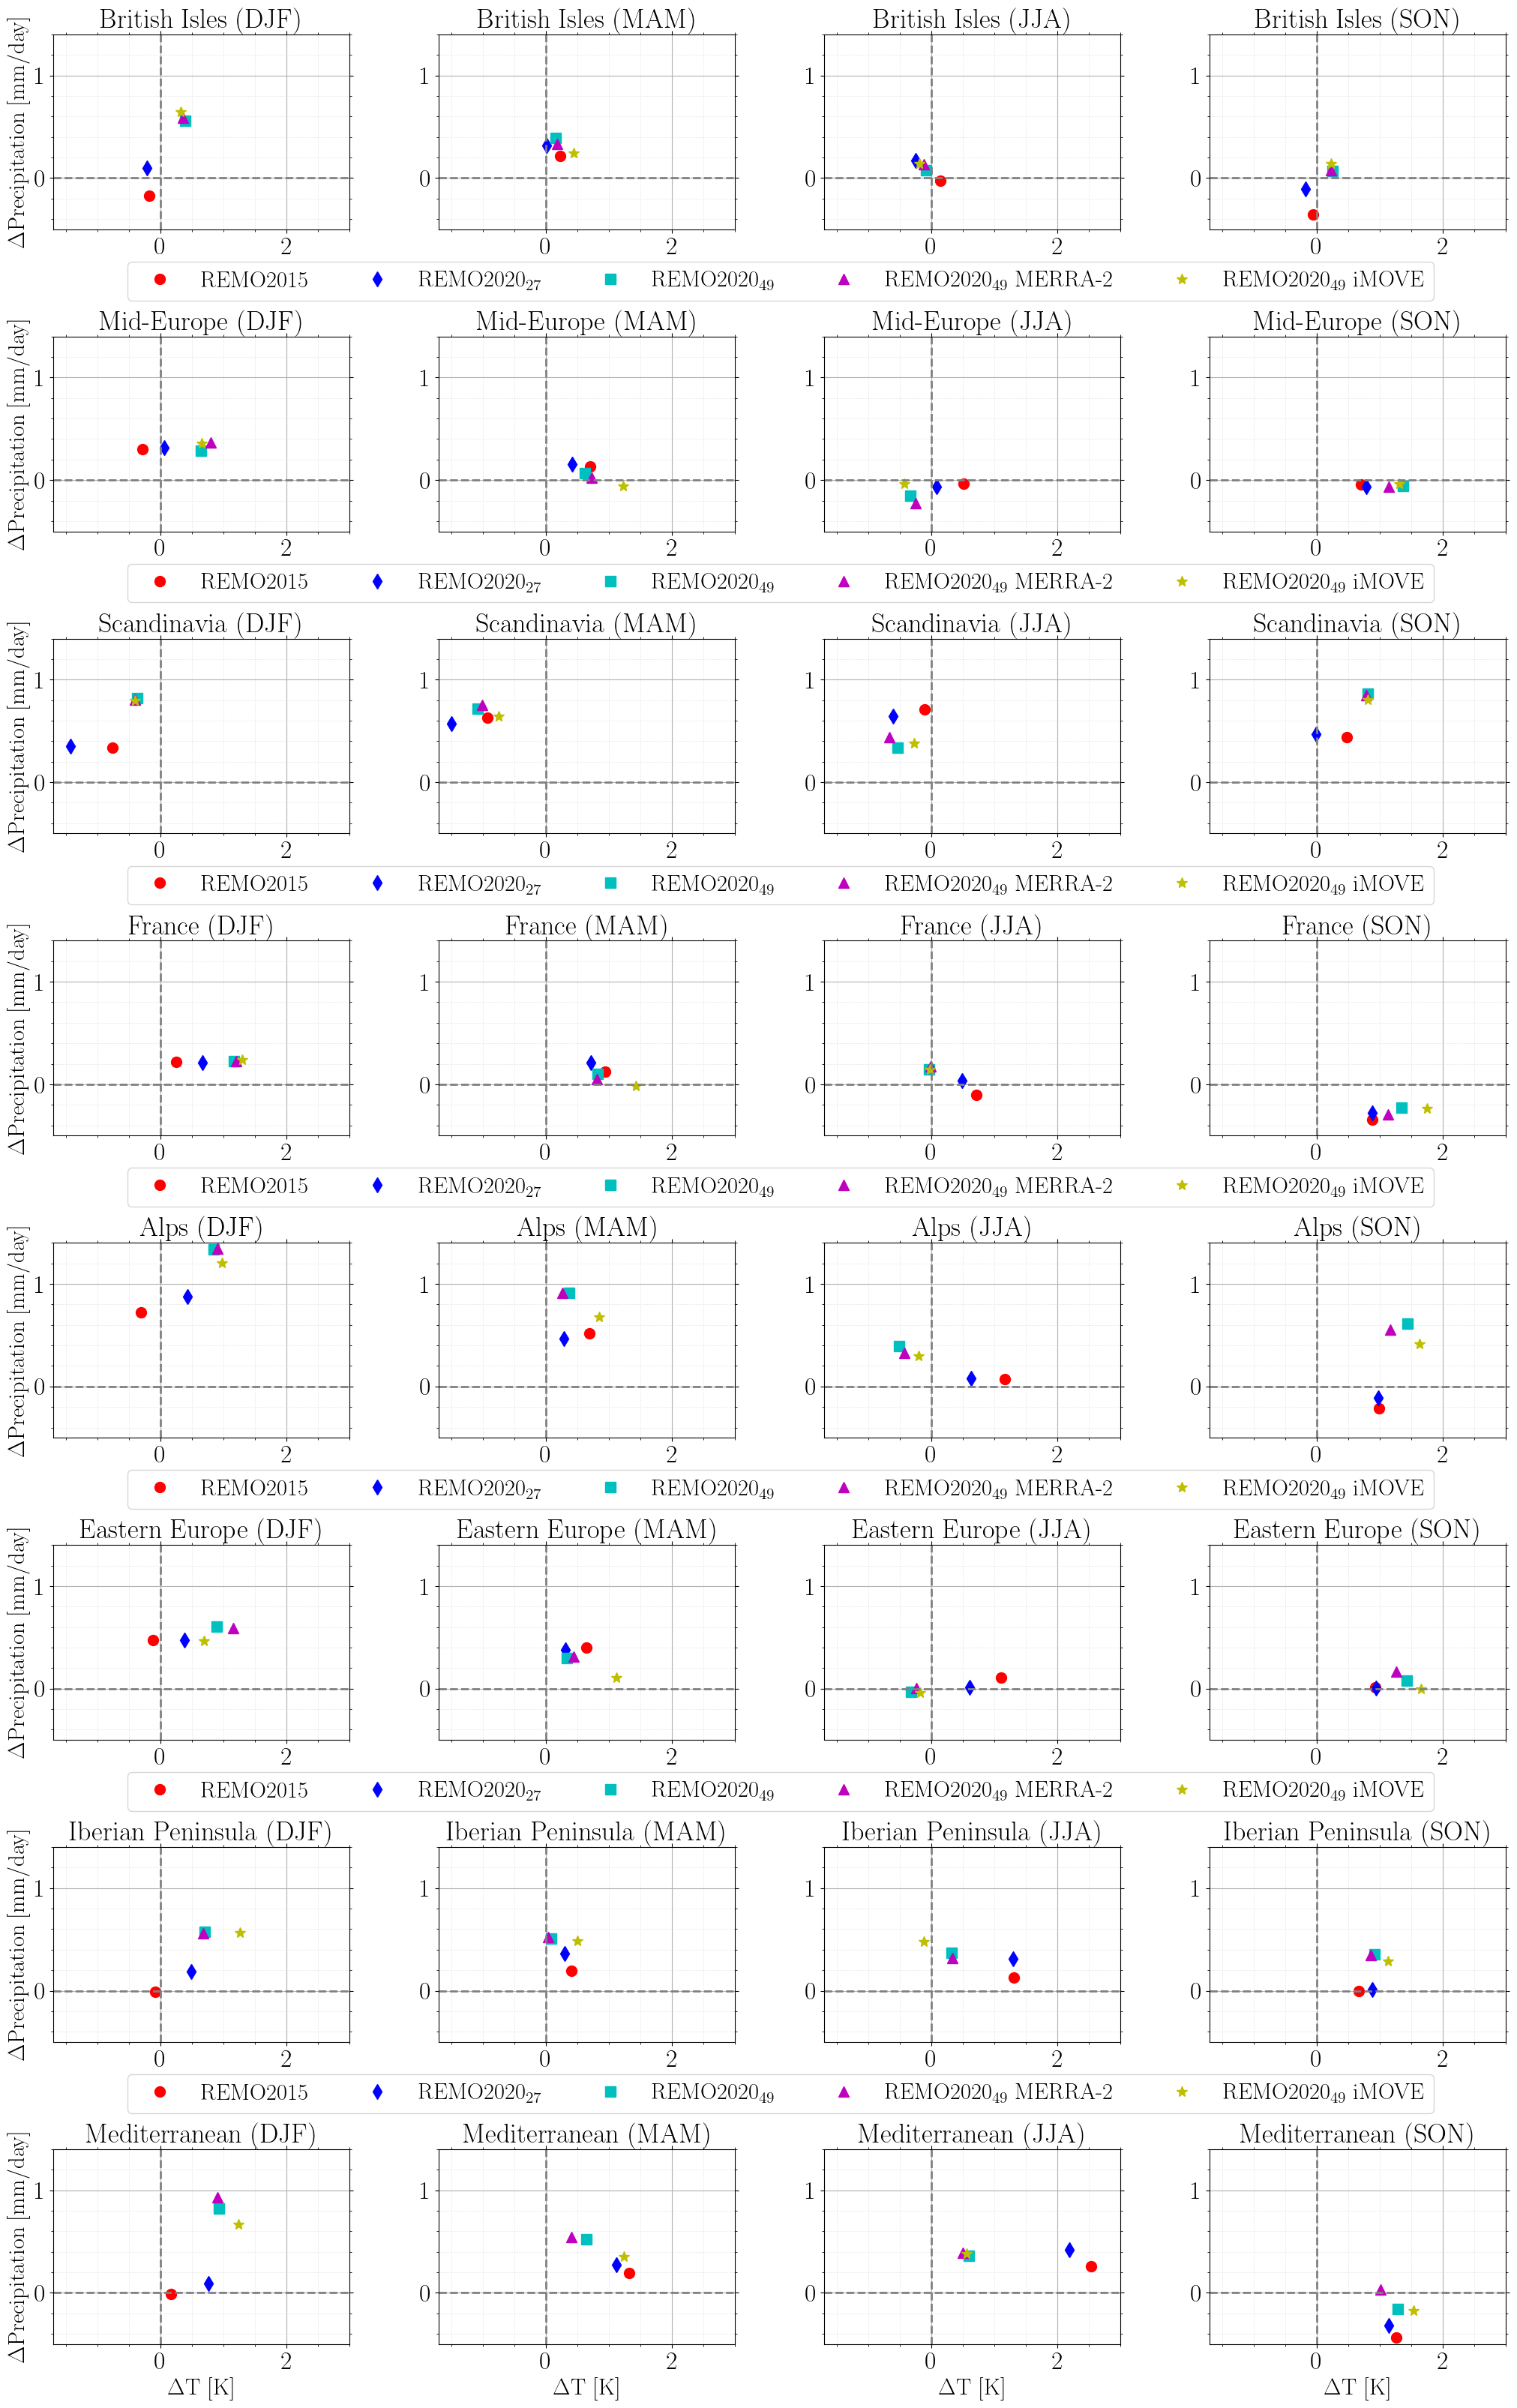

In [16]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.figsize"] = (25, 40)
plt.rcParams["figure.subplot.hspace"] = 0.7
plt.rcParams["axes.titlesize"] = 26
plt.rcParams['axes.labelsize'] = 22
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.labeltop"] = False
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.labelleft"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["ytick.labelright"] = False
plt.rcParams['lines.markersize'] = 10
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.rc('legend',fontsize=22)


gs = gridspec.GridSpec(8,4)
sb = [] # plots
ind = 0 #plot index
for reg in range(len(regorder)):
    # find the index of the region (allows plotting in different order)
    regi = list(dtemp2runs[0].vardiff.abbrevs.values).index(regorder[reg]) #
    for iseas in range(len(seasons)):
        sb = np.append(sb,plt.subplot(gs[ind]))
        for t2, pr in zip(dtemp2runs,ddayprecruns): # loop over simulations
            plt.plot(t2.vardiff.Dtemp2.isel(region=regi).sel(season=seasons[iseas]).values,pr.vardiff.Ddayprec.isel(region=regi).sel(season=seasons[iseas]).values,t2.plstyle)
        # set some plot styles etc.
        titletext = str(t2.vardiff.Dtemp2.isel(region=regi).sel(season=seasons[iseas]).names.values)+' ('+seasons[iseas]+')'
        plt.title(titletext) # title
        plt.xlim([-1.7,3.0]) # some limits
        plt.ylim([-0.5,1.4]) # some limits
        plt.grid() # make grid and modify it
        plt.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)
        plt.minorticks_on() # use minor ticks
        plt.axhline(0.0, linestyle='--', color='grey',linewidth=2.0) # add horizontal zero line
        plt.axvline(0.0, linestyle='--', color='grey',linewidth=2.0) # add vertical zero line
        ind = ind + 1 # add counter
        # add xlabel if last region
        if(regorder[reg] == regorder[-1]):
            plt.xlabel("$\Delta$T [K]")
        # add ylabel if first season
        if(iseas == 0):
            plt.ylabel("$\Delta$Precipitation [mm/day]")
    if(regorder[reg] != regorder[-1]): # add legend unless the last region
        leg=plt.legend(([obj.runame for obj in dtemp2runs]),loc=(-3.65,-0.365), ncol=5)
        leg.draw_frame(True)

# add some space
plt.subplots_adjust(wspace=0.3,hspace=0.55)
# save figure
plt.savefig(figpath+'dtemp2dpreci_prudence.png',format="png",bbox_inches='tight', pad_inches=0)